# Optimization of a plate subjected to buckling loads

The code snipets are supposed to present the major functionalities  of composipy.

## Plate buckling analysis

The buckling_analysis() core method solves a eigenvalue problem like
$$([K]-λ[K_G ]){c}={0}$$
where $[K]$ is the stiffeness matrix of the panel, $[K_G]$ is the geometrical stiffness matrix that depends on internal loads, ${c}$ is the vector of Ritz constants that determines the buckled shape and $λ$ is the eigenvalue, that determines the critical buckling load. More details about this formulation are found at [1].


Critical eigenvalue is  26.6 N/mm


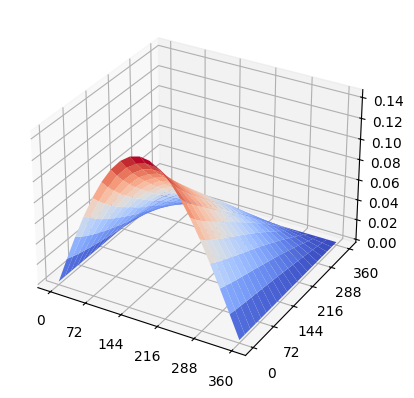

In [1]:
from composipy import OrthotropicMaterial, LaminateProperty, PlateStructure

#Ply Material Properties
E1 = 60800 #MPa
E2 = 58250 #MPa
v12 = 0.07
G12 = 4550 #MPa
t = 0.21 #mm

# Plate geometry
a = 360. #mm
b = 360. #mm
m = 7 # discretization in x direction
n = 7 # discretization in y direction

# Stacking sequence
stacking = [45,-45,0,90,45,-45,0,90,45,-45] #angles in degrees
stacking += stacking[::-1] # symmetry

material = OrthotropicMaterial(E1, E2, v12, G12, t)
laminate = LaminateProperty(stacking, material)

# Plate boundary conditions
constraints={
                'x0': ['TX', 'TY', 'TZ'],
                'xa': ['TX', 'TY', 'TZ'],
                'y0': [],
                'yb': ['TX', 'TY', 'TZ'],
            }

#Plate loads
Nxx = -1
Nyy = -0.5
Nxy = 0.5

panel = PlateStructure(dproperty=laminate, a=a, b=b, m=m, n=n, Nxx=Nxx,
                       Nyy=Nyy, Nxy=Nxy, constraints=constraints)
eigenvalue, eigenvector = panel.buckling_analysis()
print(f'Critical eigenvalue is {eigenvalue[0]: .1f} N/mm')
panel.plot_eigenvalue()

## Maximize Critical Buckling Load

The maximize_buckling_load() function solves a optimization problem like 
$$max⁡λ( W_1, W_3 )$$
$$g_1=W_3+2W_1-1≥0$$
$$g_2=W_3-2W_1+1≥0$$
$$-1≤W_1, W_3≤1	$$
that finds the pair of lamination parameters $( W_1, W_3 )$ that maximizes buckling load, given the constraints $g_1$ and $g_2$. The flexural Lamination Parameters, established by [14], are


$$W_1 => cos(2\theta) $$
$$W_2 => sin(2\theta) $$
$$W_3 => cos(4\theta) $$
$$W_4 => sin(4\theta) $$

where $θ_l$ is the angle of the laminate in continuous dominium and $h$ is the laminate thickness. 
For practical reasons, only Lamination Parameters $W_1$ and $W_3$ are used as project variables, while $W_2$ and $W_4$ are considered equal zero, therefore a symmetric and balanced laminated is considered. For more details on how to interpret them and convert them into a feasible stacking sequence, check the references [1], [2] and [3].


### Objective function with boundary g1 and g2

generating plot...


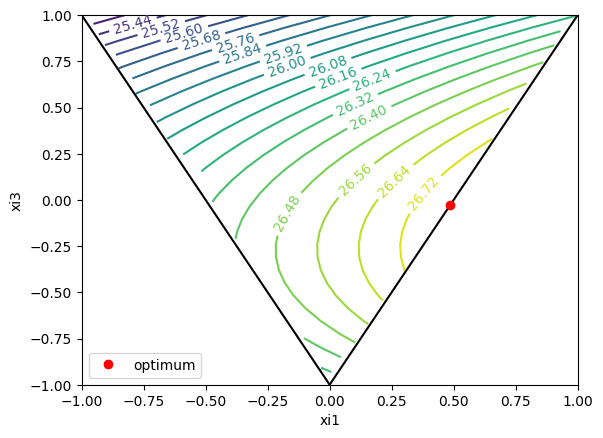

W1= 0.487 and W3=-0.026


In [2]:
from composipy.optimize import maximize_buckling_load

total_thickness = 20*0.21 #4.2 mm
res = maximize_buckling_load(a=a, b=b, T=total_thickness, E1=E1, E2=E2,
                            v12=v12, G12=G12, Nxx=Nxx, Nyy=Nyy,
                            Nxy=Nxy, m=m, n=n, panel_constraint=constraints,
                            plot=True, penalty=True) #remove plot=True to gain performance

print(f'W1={res.x[0]: .3f} and W3={res.x[1]: .3f}')

### Objective function without boundary g1 and g2

In [3]:
total_thickness = 20*0.21 #4.2 mm
res = maximize_buckling_load(a=a, b=b, T=total_thickness, E1=E1, E2=E2,
                            v12=v12, G12=G12, Nxx=Nxx, Nyy=Nyy,
                            Nxy=Nxy, m=m, n=n, panel_constraint=constraints,
                            plot=True, penalty=False) #remove plot=True to gain performance

print(f'W1={res.x[0]: .3f} and W3={res.x[1]: .3f}')

generating plot...


KeyboardInterrupt: 

## Minimize Panel Weight

The minimize_panel_weight() function solves a optimization problem like
$$min⁡V(T, W_1, W_3 )=T^3 $$
$$g_1=λ(T, W_1, W_3 )-1≥0 $$
$$g_2=W_3+2W_1-1≥0 $$
$$g_3=W_3-2W_1+1≥0 $$
$$T>0 $$
$$-1≤W_1, W_3≤1	$$

that minimizes the volume of the plate submitted to the constraints $g_1$, $g_2$ and $g_3$. Where $T$, the total thickness of the plate, is used as design variable. 


In [3]:
from composipy.optimize import minimize_panel_weight

res = minimize_panel_weight(a=a, b=b, E1=E1, E2=E2,
                            v12=v12, G12=G12, Nxx=26.6*Nxx, Nyy=26.6*Nyy,
                            Nxy=26.6*Nxy, m=m, n=n, panel_constraint=constraints)

print(f'T={res.x[0]: .3f} W1={res.x[1]: .3f} and W3={res.x[2]: .3f}')

T= 4.190 W1= 0.487 and W3=-0.026


## References

- [1] SILVA, Rafael Pereira da. Composite Plate optimization combining semi-analytical model, Lamination Parameters and a Gradient-Based Optimizer. 2023. 82f. Dissertation of Master of Science – Instituto Tecnológico de Aeronáutica, São José dos Campos.
- [2] Miki, M. Sugiyama, Y. (1993). Optimum Design of Laminated Composite Plates Using Lamination Parameters. Aiaa Journal - AIAA J. 31. 921-922. 10.2514/3.49033.
- [3]	Gurdal, Z.; Haftka, R. T. Elements of Structural Optimization. Third revised and expanded edition. Springer-Science Business Media, B. V. 1991.